# CHEM 60 - February 28th, 2024 (Navigating Potential Energy Surfaces)

Today, we are going to work on the algorithms that let us navigate potential energy surfaces (and let us predict reaction pathways!).

To get started, click on '**File**' in the left menu, then '**Save a copy in Drive**' to ensure you are editing *your* version of this assignment (if you don't, your changes won't be saved!). After you click '**Save a copy in Drive**' a popup that says **Notebook copy complete** should appear, and it may ask you to <font color='blue'>**Open in a new tab**</font>. When open, your new file will be named `Copy of CHEM60_Class_12_....ipynb` (you may want to rename it before/after you move it to your chosen directory).

#Imports

Here are the Python imports that we will need today. A tiny bit of default formatting is thrown in here (I like my font sizes to be larger than the default settings).

Run the below code block to get started.

In [37]:
# Standard library imports
import math as m

# Third party imports
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

# This part of the code block is telling matplotlib to make certain font sizes exra, extra large by default
# Here is where I list what parametres I want to set new defaults for
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
# This line updates the default parameters of pyplot (to use our larger fonts)
plt.rcParams.update(params)

First, mount the Drive. You hopefully remember this from week 0. If the details of things like imports or data access need to be clarified, go back and check out the [class 0](https://colab.research.google.com/drive/1q96pdc5CBfjhqkALe-ohqPJwNMcXzwqS?usp=share_link) notebook on this.

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Assuming you ended up with `Mounted at /content/gdrive`, you're good to move on!

# Thinking about those potential energy surfaces...

Let's go back to Monday's hydrogen exchange reaction:

\begin{equation}
H_A + H_B H_C \rightarrow H_A H_B + H_C
\end{equation}

and load in the potential energy surface you calculated:

In [39]:
data = np.load("/content/gdrive/Shared drives/Chem_60_Spring_2024/In_Class_Notebooks/data/class12_PES_hydrogen_exchange.npz")
dist_AB_g = data['dist_AB_g']
dist_BC_g = data['dist_BC_g']
energy_g = data['energy_g']

This was generated using a 25x25 point grid:


```
npts_AB = 25
npts_BC = 25
dist_AB = np.linspace(0.6,2.0,npts_AB)
dist_BC = np.linspace(0.6,2.0,npts_BC)
```



We can (and always should) double check that the dimensions of the thing we loaded match out expectations:

In [40]:
dist_AB_g.shape, dist_BC_g.shape, energy_g.shape

((25, 25), (25, 25), (25, 25))

Okay, good. Now, let's plot it again to make sure it looks like we remember it looking.

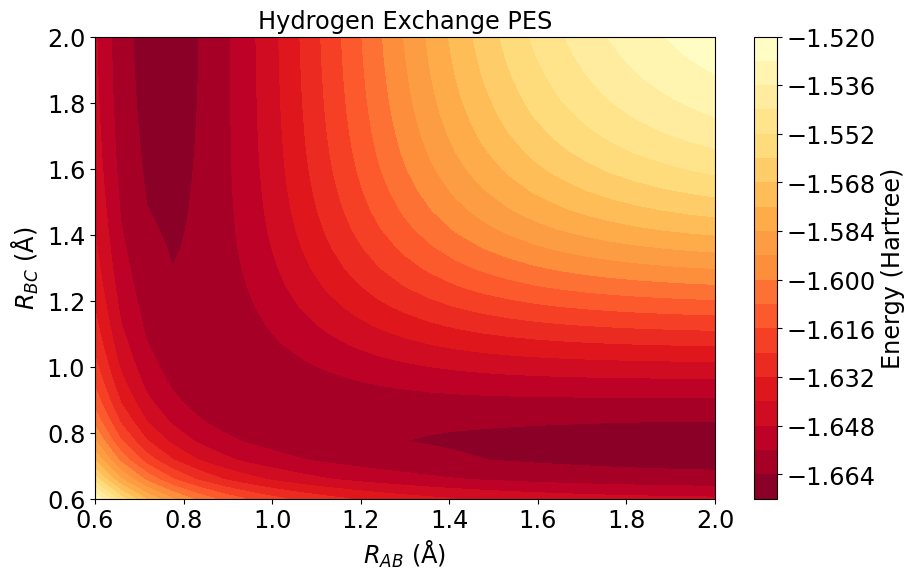

In [41]:
# plot the path on the contour plot
plt.figure(figsize=(10,6))
contour = plt.contourf(dist_AB_g, dist_BC_g, energy_g, levels=20,cmap=cm.YlOrRd_r)
plt.xlabel('$R_{AB}$ (Å)')
plt.ylabel('$R_{BC}$ (Å)')
colour_bar = plt.colorbar(contour)
colour_bar.set_label('Energy (Hartree)')
plt.title('Hydrogen Exchange PES')
plt.show()

# Gradient Descent

So you want to find some local minima? Why not try gradient descent? The gradient descent algorithm is a classic optimization technique for finding the minima of functions. It works for all kinds of applications (and sometimes, spectacularly fails!).

First of all, you need to derive the gradient, which for our purposes is the first derivatives for each dimension of the energy function. In Python, numpy's gradient function can be used to calculate the gradient of any N-dimensional array, like so.

In [42]:
gradient_x, gradient_y = np.gradient(energy_g)

Now, `gradient_x` and `gradient_y` are 2D arrays representing the gradients along the x and y-directions (dist_AB_g and dist_BC_g directions, respectively).

Why gradients? Think of yourself standing on a hill and needing to get to the bottom. For some reason, you can't see all the way down (presumably, the LA smog), but you can see a step in all directions to at least know which way is down. So, you take a step in the direction that is down. Then, you look around again and find the downward direction before taking another step. You keep doing this until you get to a point where you can't move down anymore (hopefully, you are at the bottom of the hill!). This is basically what we are doing to find the energy minima here.

For our particular application, the hill is the energy landscape, and we can step through our reaction coordinate space to find the energy minima. The gradient determines the "direction of the step" in each iteration.


Why gradient descent works well:

1. It's simple and easy to implement.
2. It's pretty fast!
3. It's flexible and can be integrated with other optimization algorithms.

A critical aspect to notice about gradient descent is that it will find a local minimum, not necessarily the global minimum. This means that the initialization of the algorithm (where you start on the PES) and the nature of the function's surface itself will determine what kind of solutions you find (and how useful they are).

Some situations where gradient descent might not work well include cases where the function has a lot of noise, the function is discontinuous, or there are a lot of local minima where the gradient might get stuck. There are typically modifications to gradient descent to help in these cases, but sometimes, other algorithms just make more sense.

Let's look at an example of gradient descent on a - perhaps - easier to think about function first, the Rosenbrock curve.



## Rosenbrock

The Rosenbrock function is a classic "test" function that is often used to demonstrate the performance of optimization algorithms. The function looks kind of simple, being defined as:

$$f(x,y) = (a - x)^2 + b (y - x^2)^2$$

It has a global minimum at (a,a^2), where the function evaluates to 0, usually set to a = 1 and b = 100 (so f(1,1) = 0).

The Rosenbrock function is interesting because, while the minimum is easily to analytically, optimization algorithms struggle! That is because there is a narrow and curve minimum valley to move through. Poorly optimized optimization algorithms (including gradient descent if set up without best case parameters), can end up search circling around the minimum or just getting stuck somewhere. That's why it's a classic function to test things out with!

Let's try it.

In [43]:
def rosenbrock(x, y): # a =1, b = 100
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

Did I write this correctly?? Let's see!

In [44]:
# make data for plots
X = np.linspace(-2, 2, 200)
Y = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(X, Y)

And to plot it

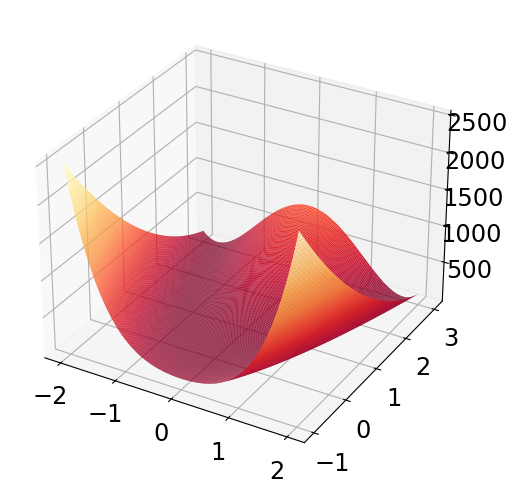

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.YlOrRd_r)
plt.show()

3D plots don't always spark joy. Let's look at it this way.

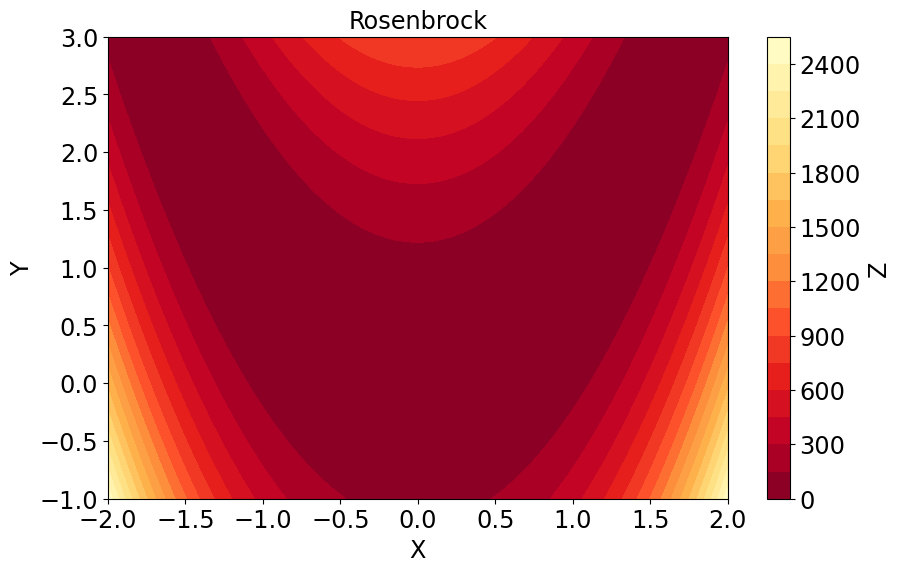

In [46]:
# plot the path on the contour plot
plt.figure(figsize=(10,6))
contour = plt.contourf(X, Y, Z, levels=20,cmap=cm.YlOrRd_r)
plt.xlabel('X')
plt.ylabel('Y')
colour_bar = plt.colorbar(contour)
colour_bar.set_label('Z')
plt.title('Rosenbrock')
plt.show()

Hey, that actually looks a bit like a PES (I wonder why I picked this function...)!

Okay. Now, because this is a smooth function, we can write its derivative (gradient) if we remember calculus (or uh, remember how to Google things like me).

In [47]:
def rosenbrock_gradient(x, y):
    dx = -2 * (1 - x) - 400 * x * (y - x ** 2)
    dy = 200 * (y - x ** 2)
    return np.array([dx, dy])

Now, let's look at what gradient descent means here (it's a simple function)!

In [48]:
# Gradient descent
x, y = np.random.uniform(-2, 2, 2)
lr = 0.001 # "learning rate"
for _ in range(5000):
    gradient = rosenbrock_gradient(x, y)
    x -= lr * gradient[0]
    y -= lr * gradient[1]

The solution is descending... by the gradient!


Did we actually find the minima doing this? Let's make a plot!

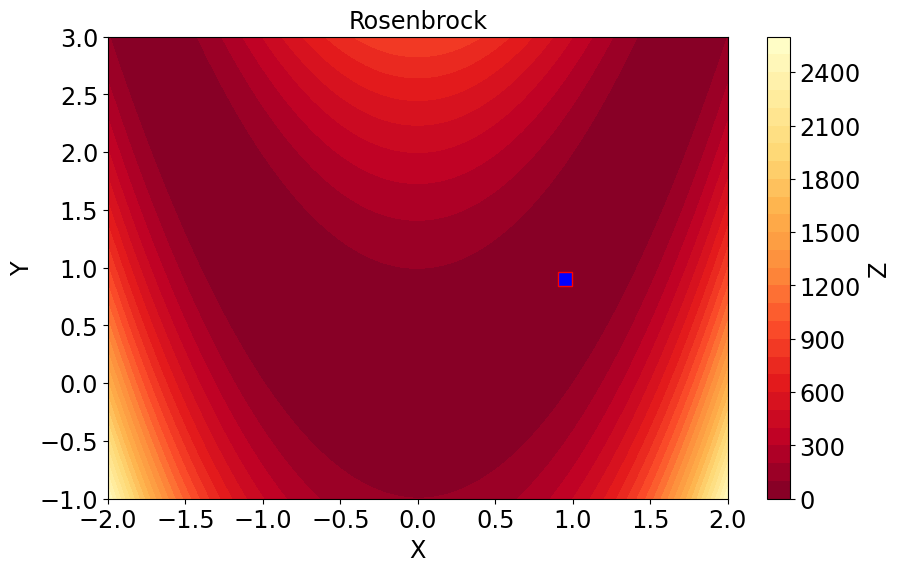

In [49]:
plt.figure(figsize=(10,6))
contour = plt.contourf(X, Y, Z, levels=30,cmap=cm.YlOrRd_r)
plt.xlabel('X')
plt.ylabel('Y')
colour_bar = plt.colorbar(contour)
colour_bar.set_label('Z')

plt.title('Rosenbrock')

# Plot the minima
ax = plt.gca()
ax.plot([x], [y], markerfacecolor='b', markeredgecolor='r', marker='s', markersize=10)

plt.show()

Honestly, that visually doesn't help me much. The blue dot is the location of the minima we found, but because the valley of the Rosenbrock is so narrow, our colour gradient can't tell us if we're truly in it.

So, let's check if we found the real minima, or at least close to it.

In [50]:
print("Gradient descent found a minimum at (" + str(round(x,3)) + "," + str(round(y,3)) + ") for Z = " + str(round(rosenbrock(x, y),3)))

Gradient descent found a minimum at (0.951,0.904) for Z = 0.002


The Rosenbrock function has a minimum Z of 0 at X = 1, Y = 1. So we basically found it!

What could we do to make these values even closer to the real values?

## PRACTICE QUESTION

Try changing things! What does the `lr` variable do? Try changing it. What if we didn't iterate through 5000 rounds of doing this? Then what happens?  


---





In [51]:
# try things?



---

The starting point is often chosen randomly, but for problems where the rough locations of local minima are known (like finding the stable states in a PES scan), the descent can be started from these points.

The choice of the learning rate (also known as the *step size*) is crucial. If too large, the method might overshoot the minima. If too small, the method may require many iterations to find the minima.

## PRACTICE QUESTION

So, we actually just have a matrix with all the Z values. Why didn't we just find the smallest value and call it a day? ie.

In [52]:
min_z_index = np.unravel_index(np.argmin(Z), Z.shape)
min_x = X[min_z_index]
min_y = Y[min_z_index]

# print("Minimum at (" + str(min_x) + "," + str(min_y) + ") for Z = " + str(Z.min()))
print("Minimum at (" + str(round(min_x,3)) + "," + str(round(min_y,3)) + ") for Z = " + str(round(Z.min(),3)))

Minimum at (0.995,0.99) for Z = 0.0


This seemed pretty fast! Why would we need an optimization algorithm if we can just find the location of the minimum value?



---



**Maybe some notes on this... also, the next section might help you think more about it**



---



## Trying it for the PES

Now, let's do it for a real potential energy surface. We'll make this as a function this time so we can call it.

In [53]:
def gradient_descent(distance_AB, distance_BC, starting_point, learning_rate, num_iterations):
    current_location = np.array(starting_point)
    path = [current_location]
    energies = []

    for _ in range(num_iterations):
        # Identify closest index of current_location in distance_AB and distance_BC arrays
        index_AB = (np.abs(distance_AB - current_location[0])).argmin()
        index_BC = (np.abs(distance_BC - current_location[1])).argmin()

        # Record energy at current location
        energies.append(energy_g[index_BC, index_AB])

        # Interpolated gradient values at current_location
        interpolated_gradient_AB = np.interp(current_location[1], distance_BC, gradient_y[:,index_AB])
        interpolated_gradient_BC = np.interp(current_location[0], distance_AB, gradient_x[index_BC,:])

        gradients = np.array([interpolated_gradient_AB, interpolated_gradient_BC])
        current_location = current_location - learning_rate * gradients
        path.append(current_location)

    return current_location, path, energies

Using the gradient descent method like this on a contour plot will only yield accurate results if the plot is a true representation of the system's energy and the sampling (i.e., the spacing of the grid points in the contour plot) is sufficient to capture the necessary details of the energy landscape.

In [54]:
def gradient_descent(distance_AB, distance_BC, starting_point, learning_rate, num_iterations):
    current_location = np.array(starting_point)
    path = [current_location]
    energies = []

    for _ in range(num_iterations):
        # Identify closest index of current_location in distance_AB and distance_BC arrays
        index_AB = (np.abs(distance_AB - current_location[0])).argmin()
        index_BC = (np.abs(distance_BC - current_location[1])).argmin()

        # Record energy at current location
        energies.append(energy_g[index_BC, index_AB])

        # Interpolated gradient values at current_location
        interpolated_gradient_AB = np.interp(current_location[1], distance_BC, gradient_y[:,index_AB])
        interpolated_gradient_BC = np.interp(current_location[0], distance_AB, gradient_x[index_BC,:])

        gradients = np.array([interpolated_gradient_AB, interpolated_gradient_BC])
        current_location = current_location - learning_rate * gradients
        path.append(current_location)

    return current_location, path, energies

## PRACTICE QUESTION

What is the same and what is different? I did more than just put this into a function.


Spend time working through each line to figure out why it is not the same as in the quick Rosenbrock example. Talk with your partners.


---



**notes for you on what is happened - you can also add comments to the above**



---


Let's test it out. Running code is often the best way to understand it (and then editing it!).

In [55]:
starting_point = (0.8, 1.5)  # these coordinates were chosen without much thought!
learning_rate = 0.1  # Also an arbitrary value. The optimal value will depend on the specific problem.
num_iterations = 10000  # The number of iterations to run.

# I want these to be 1D again
dist_AB = dist_AB_g[0,:]  # take the first row to get back dist_AB
dist_BC = dist_BC_g[:,0]  # take the first column to get back dist_BC

# Now we call the function
final_location, path, energies = gradient_descent(dist_AB, dist_BC, starting_point, learning_rate, num_iterations)


And plot

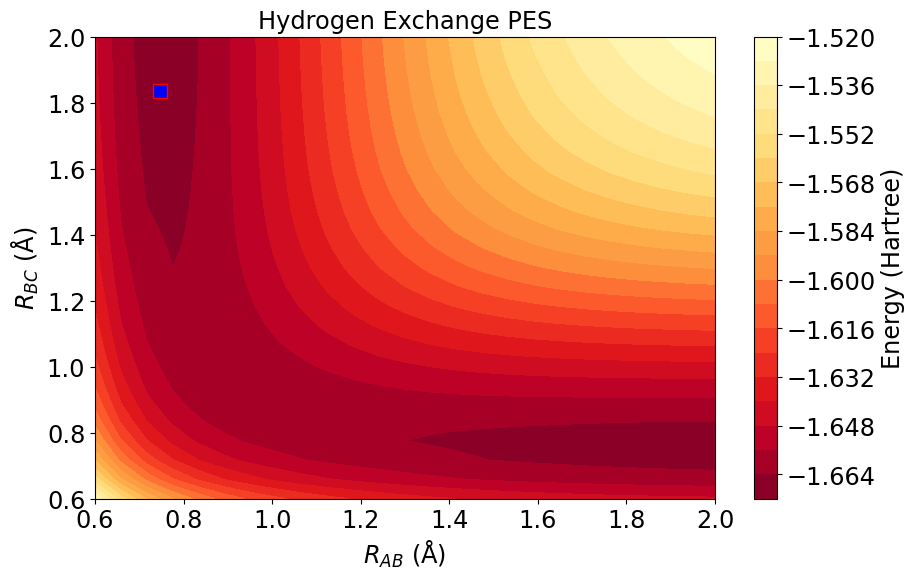

In [56]:
# plot the path on the contour plot
plt.figure(figsize=(10,6))
contour = plt.contourf(dist_AB_g, dist_BC_g, energy_g, levels=20,cmap=cm.YlOrRd_r)
plt.xlabel('$R_{AB}$ (Å)')
plt.ylabel('$R_{BC}$ (Å)')
colour_bar = plt.colorbar(contour)
colour_bar.set_label('Energy (Hartree)')

# Plot the minima
ax = plt.gca()
ax.plot(final_location[0], final_location[1], markerfacecolor='b', markeredgecolor='r', marker='s', markersize=10)

plt.title('Hydrogen Exchange PES')
plt.show()

That does look like we found a minima! Did we have to run it for so long? I set it up to run quite a long time!

```
num_iterations = 10000
```

Let's look at how it tracked energy minima over that run.



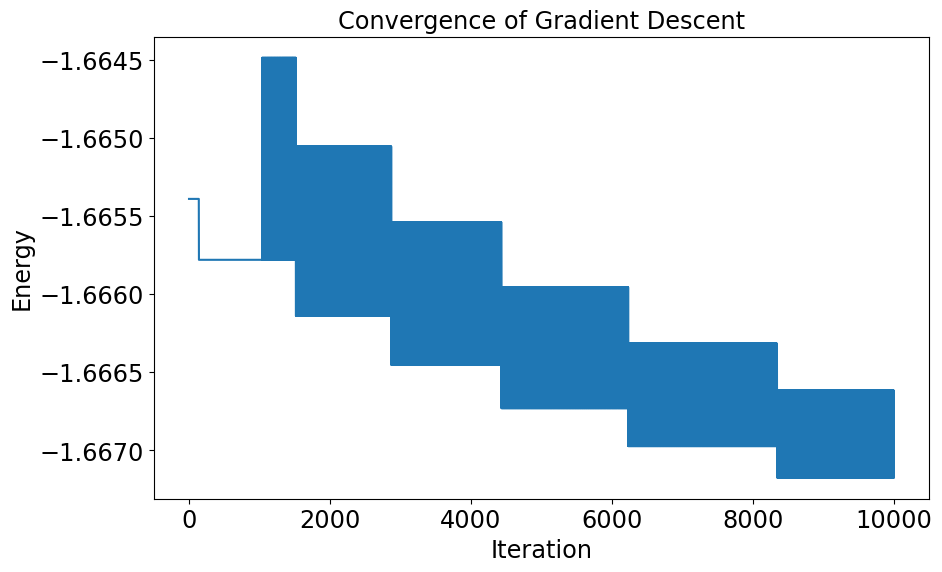

In [57]:
# Plot convergence of gradient descent
plt.figure(figsize=(10,6))
plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Convergence of Gradient Descent')
plt.show()

This is visually a mess, but highly informative!



## PRACTICE QUESTION

Looking at the above,

Could you figure out what iteration number might be better from an efficiency standpoint? ie. we want to run it the smallest number of times we can to still get the correct value.


---



In [58]:
# maybe some code?

Let's look at how it worked a different way, by actually plotting the descent.

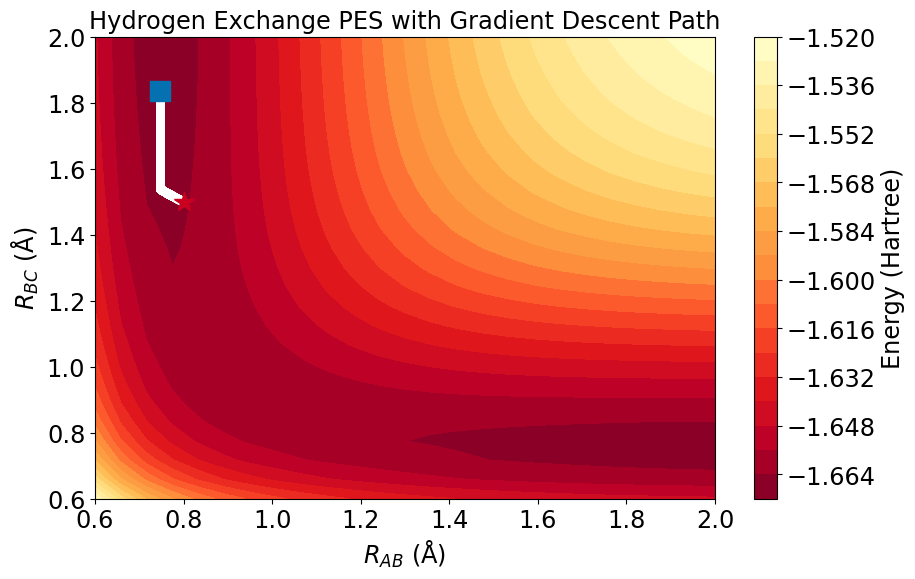

In [59]:
# to numpy array for easier slicing
path = np.array(path)

plt.figure(figsize=(10,6))
contour = plt.contourf(dist_AB_g, dist_BC_g, energy_g, levels=20,cmap=cm.YlOrRd_r)
# Plot path as a white line with circular markers
plt.plot(path[:, 0], path[:, 1], 'o-', color='white', linewidth=2, markersize=5, markerfacecolor='blue')
# Start point as a big red star
plt.plot(path[0, 0], path[0, 1], marker='*', color='#ca0020', markersize=15)
# End point as a big blue square
plt.plot(path[-1, 0], path[-1, 1], marker='s', color='#0571b0', markersize=15)
plt.xlabel('$R_{AB}$ (Å)')
plt.ylabel('$R_{BC}$ (Å)')
colour_bar = plt.colorbar(contour)
colour_bar.set_label('Energy (Hartree)')
plt.title('Hydrogen Exchange PES with Gradient Descent Path')
plt.show()

So we started really close to a minima!

Let's try starting further away and see what happens.

## PRACTICE QUESTION

Recreate the above but starting further from a minima. See how that changes things.



---



In [60]:
# You may want to copy and paste some code to edit it.



---



You might have noticed something... depending on where you start and how long you run the gradient descent, you will end up in different places! For some applications, this is a bad thing, but for ours, it is not.

Let's try starting in three locations at the same time and seeing what happens.

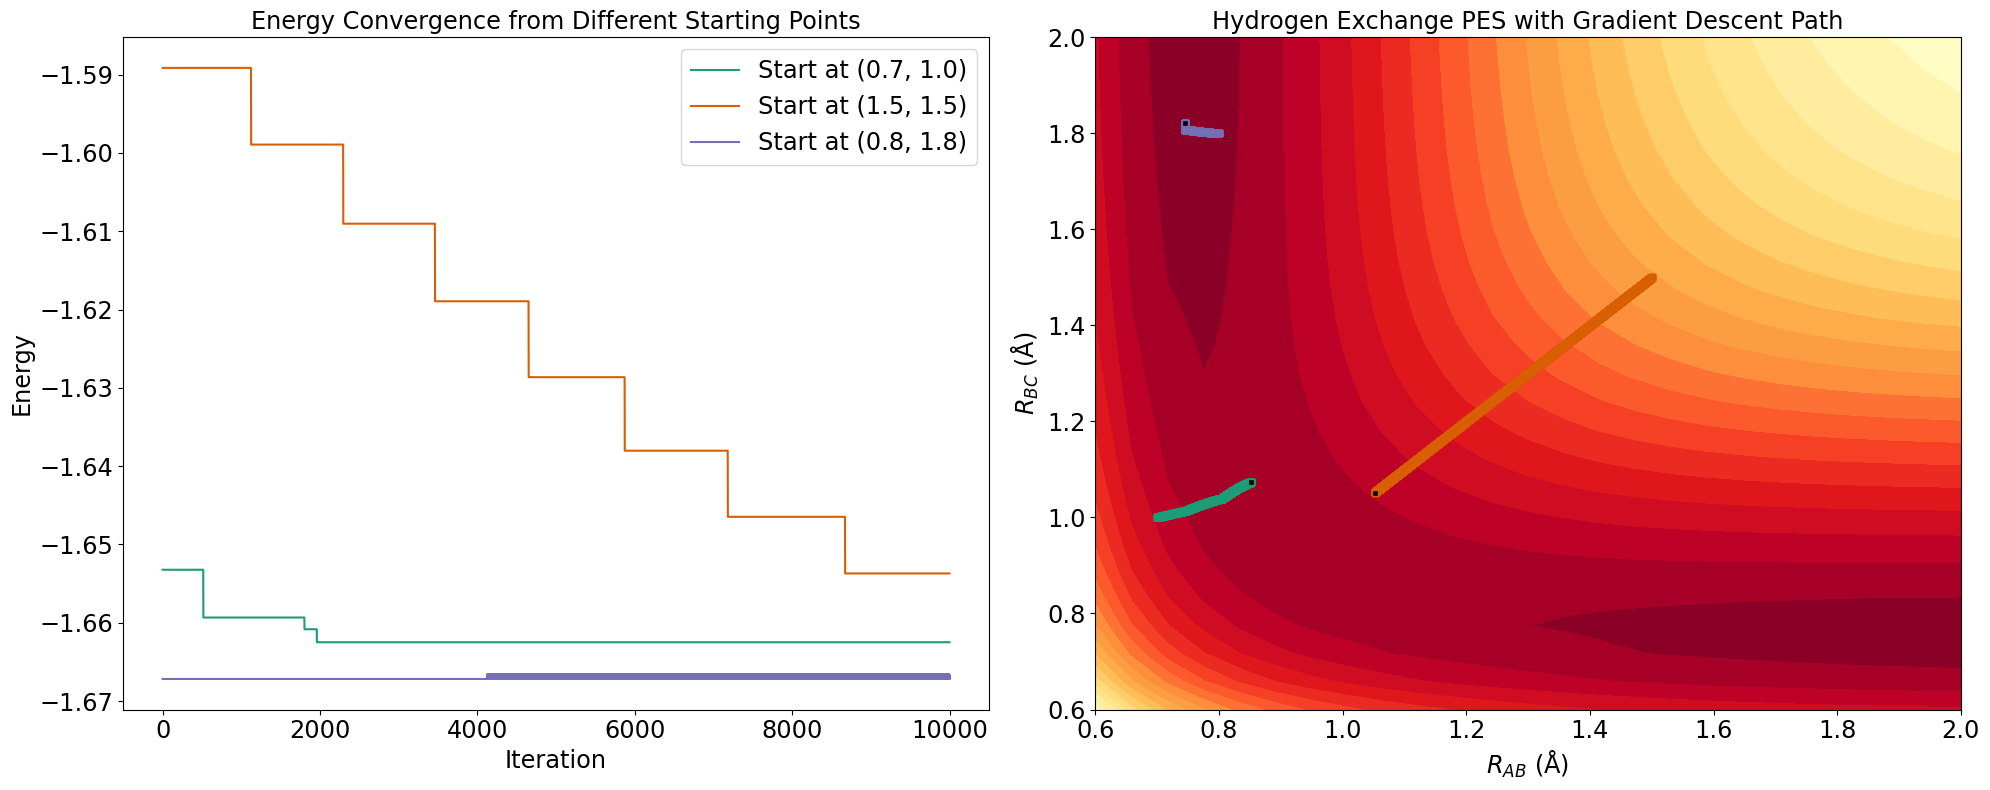

In [61]:
# Set up subplot structure
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Define some starting points and colours for each
starting_points = [(0.7, 1.0), (1.5, 1.5), (0.8, 1.8)]  # modify these according to your problem
colours = ['#1b9e77', '#d95f02', '#7570b3']

# Define learning rate and iterations
learning_rate = 0.01
num_iterations = 10000

# Prepare to store the paths and final locations
paths = []
final_locations = []

# For each starting point and colour...
for starting_point, colour in zip(starting_points, colours):
    # Perform Gradient Descent, obtain the path and energy evolution
    final_location, path, energies = gradient_descent(dist_AB, dist_BC, starting_point, learning_rate, num_iterations)

    # Append paths and final_locations to lists
    paths.append(np.array(path))
    final_locations.append(final_location)

    # On left subplot, plot energy evolution for this starting point
    ax[0].plot(energies, c=colour, label=f"Start at {starting_point}")

# Annotate left subplot
ax[0].legend()
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Energy")
ax[0].set_title("Energy Convergence from Different Starting Points")

# On right subplot, plot contour plus gradient descent paths from all starting points
contour = ax[1].contourf(dist_AB_g, dist_BC_g, energy_g, levels=20,cmap=cm.YlOrRd_r)

for path, colour in zip(paths, colours):
    ax[1].plot(path[:, 0], path[:, 1], 's-', c=colour, linewidth=2, markersize=5, markerfacecolor='k')

# Annotate right subplot
ax[1].set_xlabel('$R_{AB}$ (Å)')
ax[1].set_ylabel('$R_{BC}$ (Å)')
ax[1].set_title('Hydrogen Exchange PES with Gradient Descent Path')
plt.tight_layout()
plt.show()

This is interesting! Looks like we didn't run it long enough or start in enough places to say much though. Let's do better.

The below will be slow! Plot and compute are also happening in the same code block (I know, I know, do as I say, not as I do - sometimes when you are looping through things, it ends up being easier).

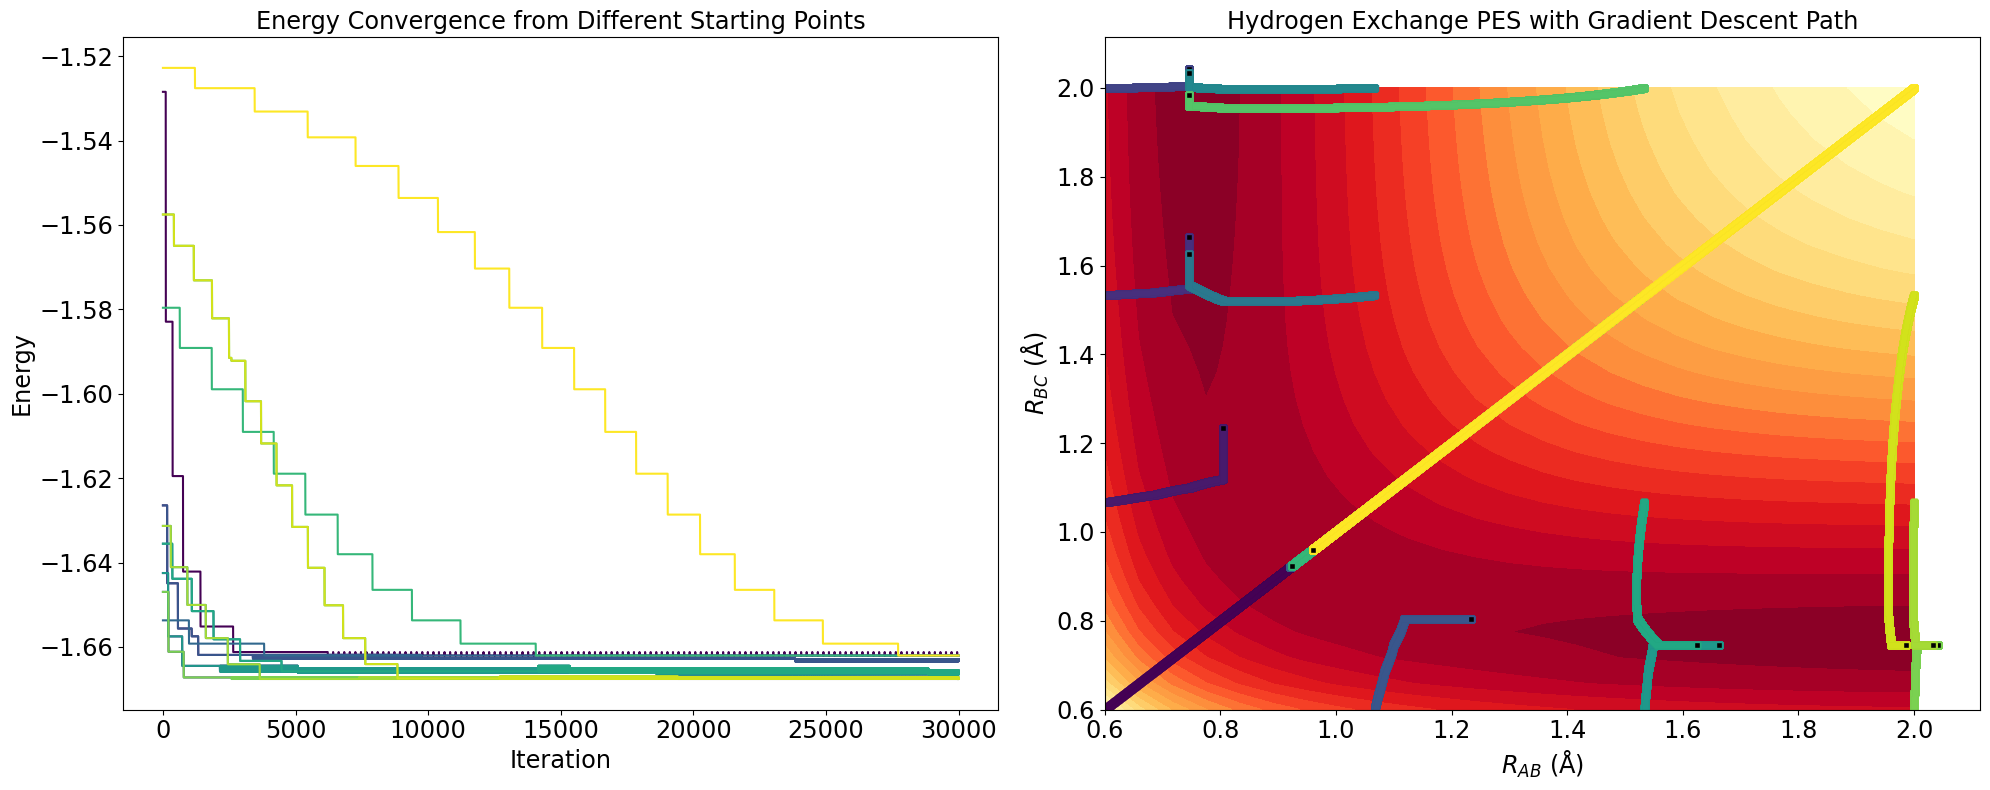

In [62]:
# Number of points on one side of the grid
grid_size = 4

# Create equally spaced values within the range of dist_AB and dist_BC
start_AB = np.linspace(dist_AB[0], dist_AB[-1], grid_size)
start_BC = np.linspace(dist_BC[0], dist_BC[-1], grid_size)

# Create a grid of starting points and associated colours
starting_points = [(ab, bc) for ab in start_AB for bc in start_BC]
colours = plt.cm.viridis(np.linspace(0, 1, len(starting_points)))

# Define learning rate and iterations
learning_rate = 0.01
num_iterations = 30000

# Prepare to store the paths and final locations
paths = []
final_locations = []

# Set up subplot structure
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# For each starting point and colour...
for starting_point, colour in zip(starting_points, colours):
    # Perform Gradient Descent, obtain the path and energy evolution
    final_location, path, energies = gradient_descent(dist_AB, dist_BC, starting_point, learning_rate, num_iterations)

    # Append paths and final_locations to lists
    paths.append(np.array(path))
    final_locations.append(final_location)

    # On left subplot, plot energy evolution for this starting point
    ax[0].plot(energies, c=colour, label=f"Start at {starting_point}")

# Annotate left subplot
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Energy")
ax[0].set_title("Energy Convergence from Different Starting Points")

# On right subplot, plot contour plus gradient descent paths from all starting points
contour = ax[1].contourf(dist_AB_g, dist_BC_g, energy_g, levels=20,cmap=cm.YlOrRd_r)

for path, colour in zip(paths, colours):
    ax[1].plot(path[:, 0], path[:, 1], 's-', c=colour, linewidth=2, markersize=5, markerfacecolor='k')

# Annotate right subplot
ax[1].set_xlabel('$R_{AB}$ (Å)')
ax[1].set_ylabel('$R_{BC}$ (Å)')
ax[1].set_title('Hydrogen Exchange PES with Gradient Descent Path')
plt.tight_layout()
plt.show()

## PRACTICE QUESTION

Discuss with your neighbours - what does this tell us? Could this actually be useful??


---



Let's find out what the minimum energy values we saw actually were?

In [63]:
# each final_location to corresponding energy value
final_energies = []
for final_location in final_locations:
    # get nearest index in dist_AB and dist_BC for final_location
    index_AB = (np.abs(dist_AB - final_location[0])).argmin()
    index_BC = (np.abs(dist_BC - final_location[1])).argmin()

    # fetch corresponding energy and add it to list
    final_energy = energy_g[index_BC, index_AB]
    final_energies.append(final_energy)

# Find minimum value among final energies
min_final_energy = np.min(final_energies)
min_final_energy_idx = np.argmin(final_energies)

# Identify the position (final location) corresponding to the lowest final energy
min_final_energy_position = final_locations[min_final_energy_idx]

print(f"Lowest energy found: {min_final_energy} at position {min_final_energy_position}")

Lowest energy found: -1.6675907032518886 at position [0.74584379 2.03312883]


Okay, this is pretty close to the global minima. Uh, so what? Does knowing this value tell us something about how the reaction proceeds? Could we have just found this another way? What about the other things we found that weren't the global minima? Were they useful? Meaningful? How does Gradient Descent work again?

## PRACTICE QUESTION

Sit and think on the above before moving on. Discuss with partners.


---



**notes**



---



# K-Means Clustering

We found things! Probably too many things. Some are essentially the same. Are there say... three fundamental regions on this potential energy surface we are likely to end up? We can find those regions with a simple clustering algorithm.

A clustering algorithm is a way to group data into sets or categories so that members of the same group (or cluster) share more similarities with each other than those in other groups. It is a method of dividing a broad dataset into multiple groups based on patterns, similarities, and differences in the data and there are many different ways to do this depending on what data we care about clustering.

What is K-means about? Imagine you are a planning a bus route because you live somewhere that prioritizes public transit. You want to pick up as many people as possible but people want to get on in all different locations. You need to optimize the time it takes to pick everyone up, so you can't stop at every address. Thankfully, humans don't live and work on a uniform grid, so certain points are naturally closer to where more people need to get picked up or dropped off than other points. By deciding to pick people up at these specific points (we could call them bus stops), the route will be faster (and use less fuel). This is basically the problem that K-means clustering solves in generality - we are optimizing for distance between members of a dataset to create subgroups.

In our context, the people represent data points (or, end points for our gradient descent), and the bus stops are the "clusters" that we're trying to find (regions of local energy minima or... settle points). By identifying these clusters, we often find a great deal of meaning.

A crucial point in K-means clustering is the selection of 'K', the number of clusters. This selection can impact the final result, and an inappropriate choice may not give you the results as expected. It is also sensitive to the initial placement of the centroids.

I wrote a version of K-means clustering below. Read through the code.



In [64]:
def kmeans_clustering(data, n_clusters, max_iterations=1000):
    # Step 1: Randomly initialize cluster centroids
    np.random.seed(0) # this makes this the same each time I run it
    idx = np.random.choice(len(data), n_clusters, replace=False)
    centroids = data[idx, :]

    for _ in range(max_iterations):
        # Step 2: Assign each data point to the nearest centroid
        # This creates a vector of size (N, ) where N is number of data points
        # Each element of vector will be in [0, K) where K is number of clusters.
        assignments = np.argmin(np.linalg.norm(data - centroids[:, np.newaxis], axis=2), axis=0)

        # Step 3: Compute new centroids as the mean of data points in each cluster
        new_centroids = np.array([data[assignments==k].mean(axis=0) for k in range(n_clusters)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return assignments, centroids

## PRACTICE QUESTION

What is this all doing? Looking through [`np.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) might help.


---



**notes for you**



---



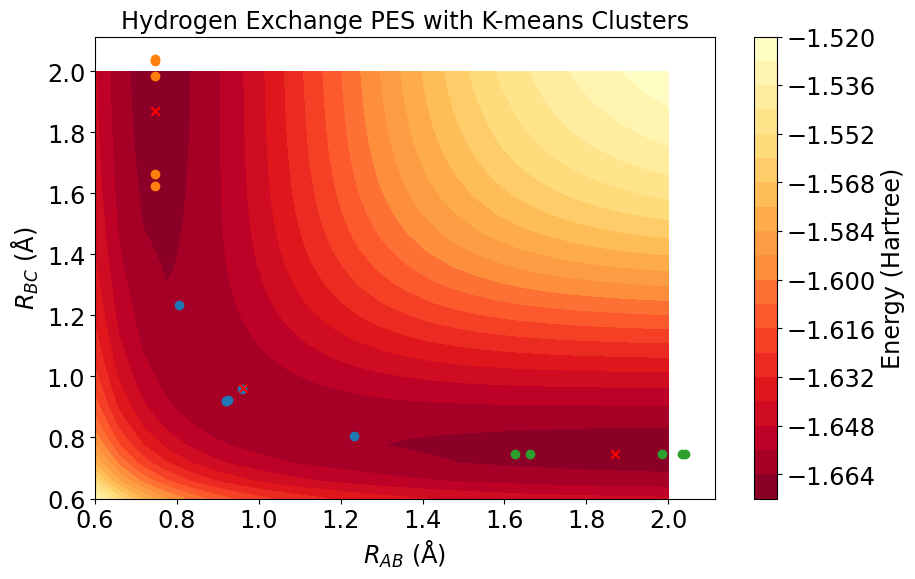

In [65]:
final_positions = np.array(final_locations)
n_clusters = 3  # Reasonable guess is that final states represent reactants and products and an intermediate
assignments, centroids = kmeans_clustering(final_positions, n_clusters)

# Plot energy contour
plt.figure(figsize=(10,6))
contour = plt.contourf(dist_AB_g, dist_BC_g, energy_g, levels=20,cmap=cm.YlOrRd_r)

plt.title('Hydrogen Exchange PES with K-means Clusters')
plt.xlabel('$R_{AB}$ (Å)')
plt.ylabel('$R_{BC}$ (Å)')
colour_bar = plt.colorbar(contour)
colour_bar.set_label('Energy (Hartree)')

# Plot final positions
for i in range(n_clusters):
    plt.scatter(final_positions[assignments == i, 0], final_positions[assignments == i, 1])

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')  # Centroids as red crosses

plt.show()

for cluster_num in range(n_clusters):
    points = final_positions[assignments == cluster_num]
    # print(f"Points in cluster {cluster_num}:")
    # print(points)

With the initial set up of:


```
# Number of points on one side of the grid
grid_size = 4
learning_rate = 0.01
num_iterations = 30000
```

And

```
n_clusters = 3
```

We should have found three points that look kind of special. What are they??



---





## PRACTICE QUESTION

Do those three centroids have any special meaning? Does this help you think about while just finding the minimum values on the energy surface (ala `min(energy_g)` doesn't give us the same *physical* information?)

Discuss!

---






**Notes?**



---



Let's look at the *states* that those three centroids (or, places we're likely to end up if travelling around this PES) might represent.

In [66]:
centroid_energies = []
centroid_indices = []

for i in range(n_clusters):
    cluster_points = final_positions[assignments == i]
    energies = []
    indices = []

    for point in cluster_points:
        index_AB = (np.abs(dist_AB - point[0])).argmin()
        index_BC = (np.abs(dist_BC - point[1])).argmin()

        energy = energy_g[index_BC, index_AB]
        energies.append(energy)
        indices.append((index_BC, index_AB))

    centroid_energies.append(np.mean(energies))
    centroid_indices.append(indices[np.argmin(energies)])

# Fetch indices of two lowest energy centroids
lowest_energy_indices = np.argsort(centroid_energies)

# Fetch corresponding indices in 'energy_g'
lowest_energy_centroid_indices = [centroid_indices[i] for i in lowest_energy_indices]

for i, index in zip(lowest_energy_indices, lowest_energy_centroid_indices):
   print(f"Centroid {i} with energy {centroid_energies[i]} corresponds to index {index} in 'energy_g'.")

Centroid 1 with energy -1.6668804657626368 corresponds to index (24, 3) in 'energy_g'.
Centroid 2 with energy -1.6668804657625862 corresponds to index (3, 24) in 'energy_g'.
Centroid 0 with energy -1.66249121826434 corresponds to index (11, 3) in 'energy_g'.


What it... I want to plot this in a different way. You may have seen this before...

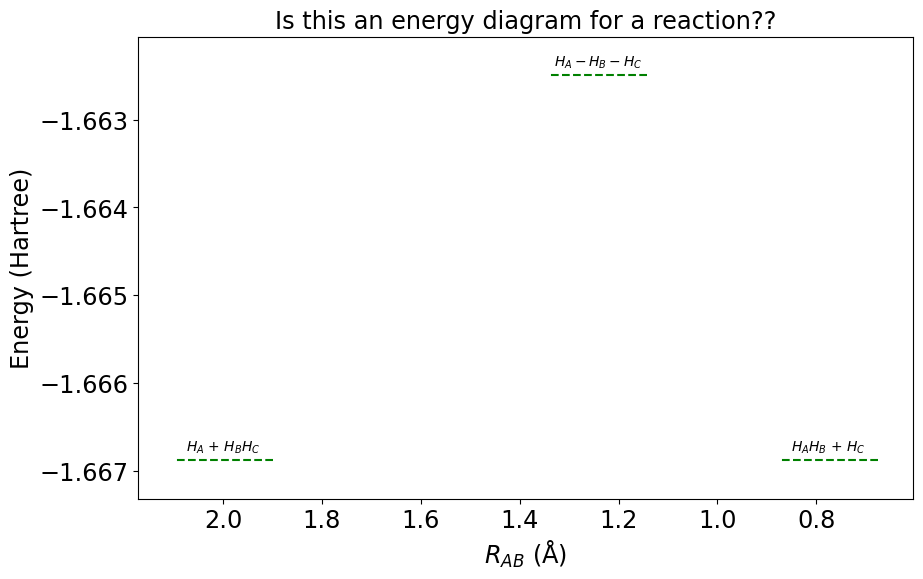

In [67]:
# Compute the energy for each state directly
E_states = np.array([centroid_energies[i] for i in lowest_energy_indices])
states = ['$H_A$ + $H_BH_C$', '$H_AH_B$ + $H_C$', '$H_A-H_B-H_C$']  # Labels for states

# Plot energy diagram
plt.figure(figsize=(10,6))
width = 0.2  # Line width (set for visual preference)

for i in range(len(lowest_energy_indices)):
    index_AB = lowest_energy_centroid_indices[i][0]
    dist_AB_value = dist_AB[index_AB]
    xmin = dist_AB_value - width/2
    xmax = dist_AB_value + width/2
    plt.hlines(y=E_states[i], xmin=xmin, xmax=xmax, linestyles='dashed', colors='g')
    plt.text(dist_AB_value, E_states[i]-(min(E_states)-max(E_states))/30, states[i], va='center', ha='center')

plt.ylim(min(E_states)+(min(E_states)-max(E_states))/10, max(E_states)-(min(E_states)-max(E_states))/10)
plt.gca().invert_xaxis()  # Invert the x-axis

plt.ylabel('Energy (Hartree)')
plt.xlabel('$R_{AB}$ (Å)')
plt.title('Is this an energy diagram for a reaction??')

plt.show()

Neat.

Okay. So what's the path? This... isn't a path. This gives us indication of the energy barrier, but we care about the full path, not just the energy of an intermediate when wanting to know if and how a reaction actually occurs.

One more weird algorithm for today.

# A Greedy Algorithm

I didn't name it! That's just what these are called. Say we know the reactants and the products are the lowest energy states on our PES. How would we travel between them through the below plot?

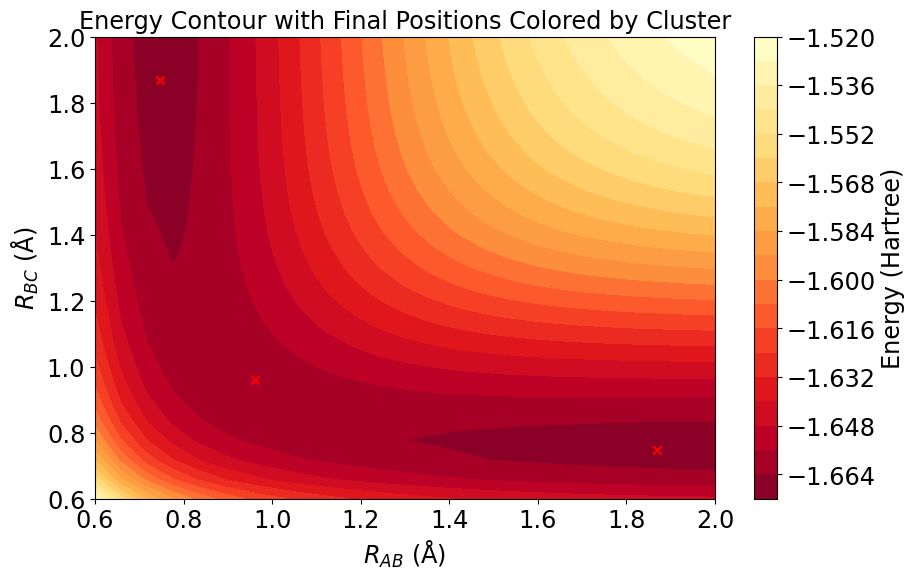

In [68]:
# Plot energy contour
plt.figure(figsize=(10,6))
contour = plt.contourf(dist_AB_g, dist_BC_g, energy_g, levels=20,cmap=cm.YlOrRd_r)

plt.title('Energy Contour with Final Positions Colored by Cluster')
plt.xlabel('$R_{AB}$ (Å)')
plt.ylabel('$R_{BC}$ (Å)')
colour_bar = plt.colorbar(contour)
colour_bar.set_label('Energy (Hartree)')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')  # Centroids as red crosses

plt.show()



This shares things in common with gradient descent, but we aren't just picking the easiest path down the hill, we are now trying to find the lowest energy route between two points. We still have to minimize a 'cost' and that cost is dependent on the energy gradient (how big a step do we need to take). The basic idea is below:

1. Start at a minimum centroid (the reactants, presumably) and record its position in our X (AB distance) and Y (BC distance) space.
2. Calculate the energy gradient at this location using. This gives us the slope of the energy in both the AB and BC directions.
3. Calculate the energy difference (or "cost") to move one step in each direction. Here, the cost will just be the magnitude of gradient corresponding to each direction.
4. Select the direction (or multiple directions) which have the lowest energy. Sometimes, several directions will basically be equivalent (think about mean and standard deviations!)
5. Move a step in the selected direction(s) and go back to step 2.

Each direction we move forms a path, so we may end up with multiple paths (we pretty much always do!). We'll record and keep track of the total energy cost, the cumulative energy climb for each path and then pick the lowest energy path in the end.

First, let's write a little function to make it easier for us to look at neighbouring values on our PES

In [69]:
def find_neighbours(location, h, w):
    x, y = location
    neighbours = []
    for a in range(-1, 2):
        for b in range(-1, 2):
            # Skip the center point and the boundaries (why??)
            if (a != 0 or b != 0) and 1 <= x + a < h - 1 and 1 <= y + b < w - 1:
                neighbours.append((x + a, y + b))
    return neighbours

Now, let's find a path!

In [70]:
def find_paths(PES, start_index, end_index):
    h, w = PES.shape
    considered = np.full(PES.shape, False)
    paths = []
    current_loc = start_index
    path = [tuple(start_index)]
    cumulative_energy = 0

    while current_loc != end_index:
        min_energy = 0.006 # np.inf (what am I doing here?)
        next_loc = None
        for loc in find_neighbours(current_loc, h, w):
            # Check if we have already been to the point.
            if considered[loc]:
                continue

            energy_diff = abs(PES[tuple(current_loc)] - PES[loc])

            if energy_diff < min_energy:
                min_energy = energy_diff
                next_loc = loc

        if next_loc is None: # An escape hatch: prevent infinite loops!
            print(f"No valid move found from location {current_loc}.")
            break
        cumulative_energy += min_energy
        current_loc = next_loc
        path.append(tuple(current_loc))
        considered[tuple(current_loc)] = True
    paths.append((path, cumulative_energy))
    return paths

You may not have time to dig into this in class, but you will get to in the homework... If you have time, try to talk through the logic of what is presented here. There is a part missing!

Let's test it

In [71]:
paths = find_paths(energy_g, lowest_energy_centroid_indices[0], lowest_energy_centroid_indices[1])

No valid move found from location (5, 23).


Okay, it tells us it stopped at a certain point. Let's look at it.

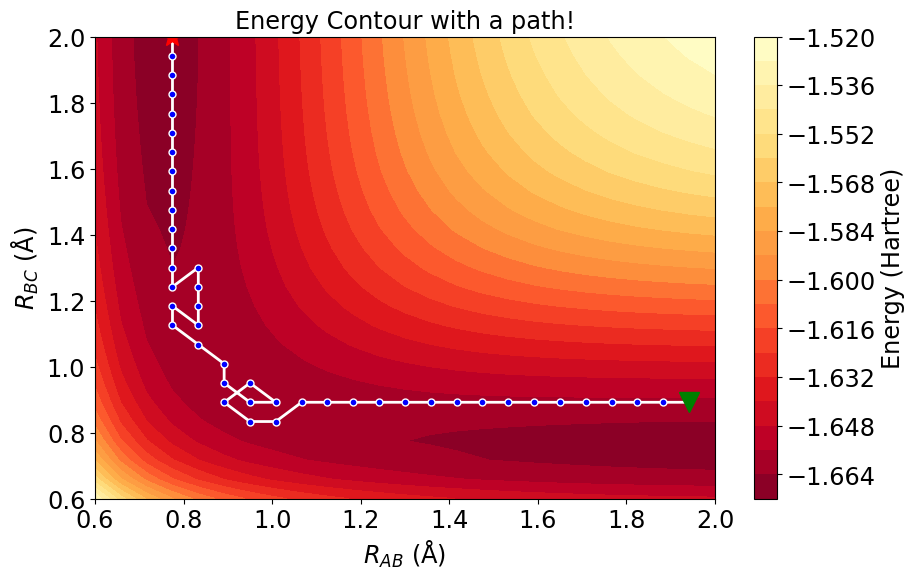

In [72]:
plt.figure(figsize=(10,6))
contour = plt.contourf(dist_AB_g, dist_BC_g, energy_g, levels=20,cmap='YlOrRd_r')

# Plot paths
for i, (path, total_energy) in enumerate(paths):   # If there are multiple paths, loop over them
    path = np.array(path)  # convert to numpy for easier slicing
    color = 'white'

    # Fetch coordinates from grid
    AB = dist_AB_g[path[:, 0], path[:, 1]]
    BC = dist_BC_g[path[:, 0], path[:, 1]]

    # Plot path as a white line with circular markers
    plt.plot(AB, BC, 'o-', color=color, linewidth=2, markersize=5, markerfacecolor='blue')

    # Start point: big red star
    plt.plot(AB[0], BC[0], marker='*', color='red', markersize=15)

    # End point: big green triangle
    plt.plot(AB[-1], BC[-1], marker='v', color='green', markersize=15)

plt.title('Energy Contour with a path!')
plt.xlabel('$R_{AB}$ (Å)')
plt.ylabel('$R_{BC}$ (Å)')
colour_bar = plt.colorbar(contour)
colour_bar.set_label('Energy (Hartree)')
plt.show()

Huh, we almost made it. We did a couple silly loops. Why?

Also, is there anything special about this path over say, several other similar ones? What makes one direction more likely if the energies in more than one direction are - statistically - indistinguishable?

If we want to find the reaction path in a complex surface, we may discover several paths are possible, some may just be more likely. In this case, we would want a bit more complexity here (that's your homework).

# Submit your notebook

It's time to download your notebook and submit it on Canvas. Go to the File menu and click **Download** -> **Download .ipynb**

Then, go to **Canvas** and **submit your assignment** on the assignment page. Once it is submitted, swing over to the homework now and start working through the paper.